In [15]:
#!/usr/bin/env python3
# inagler 16/09/23

import numpy as np          # fundamental package for scientific computing
import xarray as xr
import pop_tools
import gsw                  # compute potential density
import glob
import os

### INITIALISATION

path = '/home/innag3580/phase1_CONDA/'

# Load data events and their temporal location
data = np.genfromtxt(path+'current/events_dens_spg.csv', delimiter=',', names=True, dtype=None)

# Accessing columns by name
member_numbers = data['Index']
events = data['Values']
member_names = np.zeros(len(member_numbers))

# set periods
before = 40*12
after = 20*12

# find file names 
def find_corresponding_file_name(vvel_number_to_find):
    with open(path+'timeseries/order.txt', 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename



# SELECT TIME RANGE

In [17]:

### COMPUTATION

for i in range(0, len(member_numbers)):

    # define entire time range for event
    member = find_corresponding_file_name(member_numbers[i])[5:]
    event = events[i]*12
    period_start = event-before
    period_end = event+after
    
    print('computation member '+member+' started')

    # select time range in data arrays
    time = slice(period_start, period_end)

    # open files and take annual means 

    # 2d data
    n_heat_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/n_heat/n_heat_'+member
    ds = xr.open_dataset(n_heat_file).isel(time=time, transport_reg=1, transport_comp=1).resample(time='A').mean(dim='time')

    if 'time_bound' in ds.variables:
        ds = ds.drop_vars('time_bound')

    # save array
    ds.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_'+member)
    
    print(member+' saved')

    

computation member 1301.019.nc started


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140309750863680:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1531 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


PermissionError: [Errno 13] Permission denied: b'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1301.019.nc'

# COMPUTE 60 YEAR ANNUAL COMPOSITES

In [6]:
n_heat_files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_*.nc'))

In [11]:
var_years = []
for t in range(60):
    var_year = []
    for i in range(len(n_heat_files)):
        try:
            ds = xr.open_dataset(n_heat_files[i])
        except ValueError as e:
            continue

        ds_file = ds['N_HEAT'].isel(time=t)
        var_year.append(ds_file)

    ds_comp = xr.concat(var_year, dim='file').mean(dim='file')
    var_years.append(ds_comp)

ds_var_annual = xr.concat(var_years, dim='time')

ds_var_annual.to_netcdf('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/N_HEATcomposite.nc')

# COMPUTE PERIOD ANOMALY

In [16]:
n_heat_anomalies  = []

for i in range(len(n_heat_files)):
    try:
        ds = xr.open_dataset(n_heat_files[i])
        print(f"{n_heat_files[i]} exists")
        # Do further processing with the dataset 'ds' if needed
    except ValueError as e:
        print(f"Error opening dataset from file {files[i]}: {e}")
        # Handle the exception, for example, continue with the next file
        continue
    
    # TEMP
    period1_avg = ds['N_HEAT'].isel(time=slice(0,35)).mean(dim='time')  
    period2_avg = ds['N_HEAT'].isel(time=slice(45,59)).mean(dim='time')
    difference = period2_avg - period1_avg
    n_heat_anomalies.append(difference)

n_heat_anomaly = xr.concat(n_heat_anomalies, dim='file').mean(dim='file')
n_heat_anomaly.to_netcdf(os.path.expanduser('~/phase1_CONDA/')+'/results/composites/n_heat_anomaly.nc')

/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1231.001.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1231.003.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1231.004.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1231.020.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1251.010.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1281.010.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1281.012.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1281.015.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1281.017.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1281.020.nc exists
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/n_heat_composite_1301.001.nc exists

Plot average N_HEAT

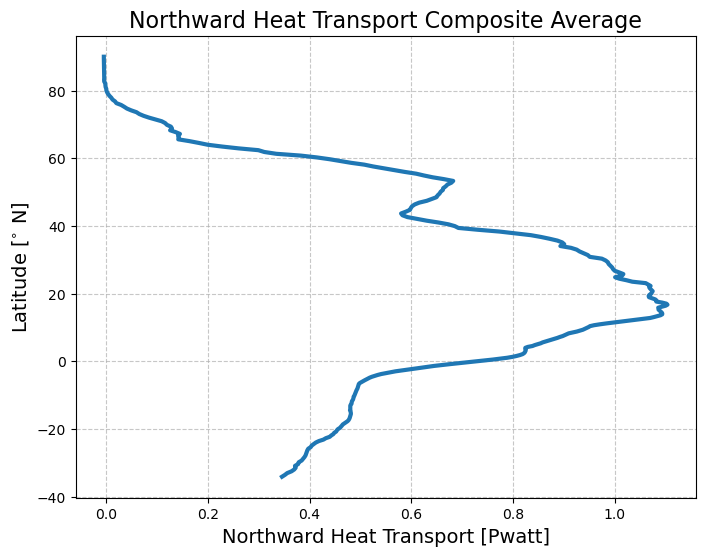

In [22]:
import matplotlib.pyplot as plt


line = ds_var_annual.mean(dim='time').values
lats = ds_var_annual.lat_aux_grid.values

plt.figure(figsize=(8, 6))
plt.plot(line, lats, linewidth=3)
plt.title('Northward Heat Transport Composite Average', fontsize=16)
plt.xlabel('Northward Heat Transport [Pwatt]', fontsize=14)
plt.ylabel('Latitude [$^{\circ}$ N]', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'n_heat_average.png', bbox_inches='tight', dpi=300)